In [1]:
import numpy as np
from qiskit import *
import matplotlib.pyplot as plt
%matplotlib inline
shots = 8192

## Measurement Error Mitigation
Zastosowanie metody Measurement Error Mitigation do zadania z 6 laboratoriów -
problem Bersteina-Vaziraniego

Zdefiniowana funkcja z założonym parametrem a.
Mamy daną funkcję nie znając parametru a. Ile razy musimy ją uruchomić aby wyznaczyć ten parametr?
W rozwiązaniu kwantowym musimy uruchomić ją tylko raz.

Poniżej układ kwantowy, z laboratorium 6, gdzie funkcja operuje na 6 kubitach.
Parametr a ma postać:
a0 = 0, a1 = 1, a2 = 0, a3 = 1, a4 =1.
Wynik pojawi się na rejestrze wejściowym (q0 - q4).

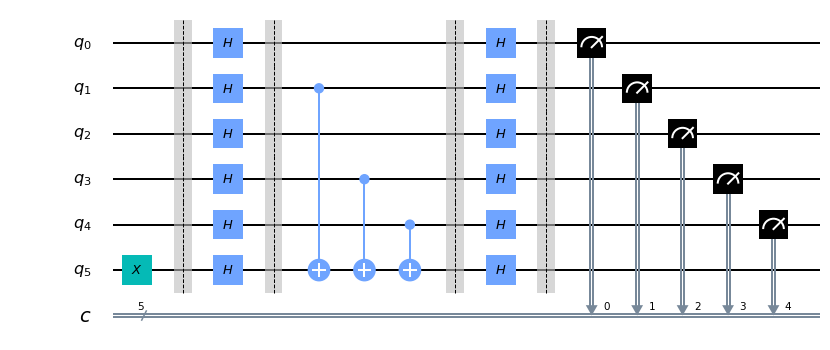

In [2]:
circ = QuantumCircuit(6, 5)
circ.x(5)
circ.barrier()
for i in range(0,6):
    circ.h(i)
circ.barrier()
circ.cx(1,5)
circ.cx(3,5)
circ.cx(4,5)
circ.barrier()
for i in range(0,6):
    circ.h(i)
circ.barrier()
for i in range(0,5):
    circ.measure(i, i)
circ.draw()

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(circ, backend_sim, shots=shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
# provider.backends()

backend = provider.get_backend('ibmq_16_melbourne')

from qiskit.tools.monitor import job_monitor

job_exp = execute(circ, backend=backend, shots=shots)
job_monitor(job_exp)

Job Status: job has successfully run


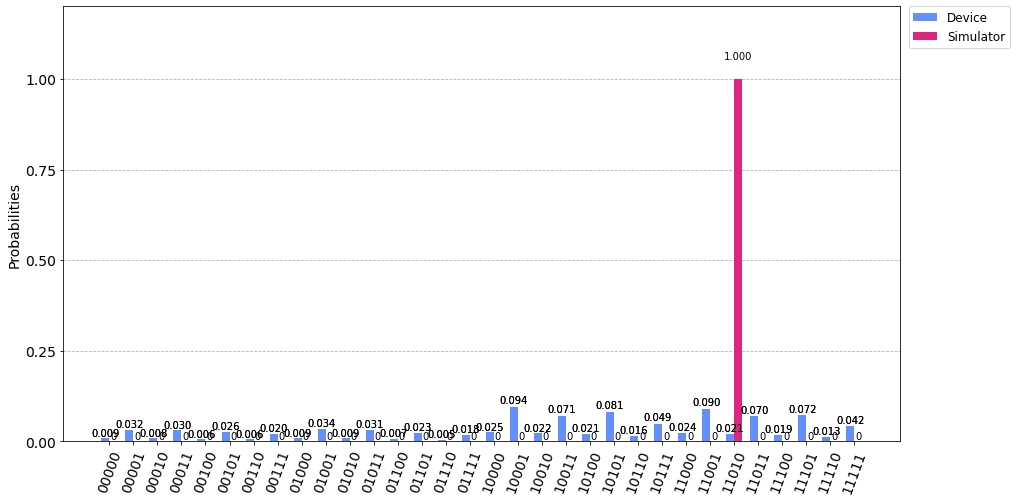

In [4]:
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(circ)
from qiskit.visualization import plot_histogram
plot_histogram([counts_exp,counts], legend=['Device', 'Simulator'],figsize=(15,8))

# Korekcja błędów pomiaru
Jedną z form szumu jest ta która powstaje podczas ostatecznego pomiaru. Możemy sobie z nią prosto poradzić określając dokładnie jakie są błędy pomiaru.
Przygotowane zostają wszystkie możliwe podstawowe stany (2^n) i są natychmiast mierzone. Określane jest prawdopodobieństwo dla każdego z wyników.
Taka procedura zostanie zastosowana poniżej do układu z laboratorium 6.

In [5]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

Tworzenie obwodów kalibracyjnych.

In [6]:
cal_circuits, state_labels = complete_meas_cal(qr=QuantumRegister(5), circlabel='measerrormitigationcal')

Przetestowane będą wszystkie możliwości dla kubitów które przechodzą końcowy pomiar, a więc dla 5 kubitów powstaną 32 obwody kalibracyjne.

In [7]:
len(cal_circuits)

32

Przykładowy, trzeci układ kalibracyjny.

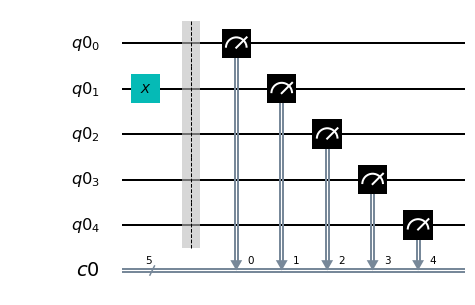

In [8]:
cal_circuits[2].draw()


Uruchamiamy wszystkie obwody kalibracyjne, aby dowiedzieć się, jakie błędy powstają dla każdego z nich.
Optimization level 0 oznacza, że ukłądy nie będą zmieniane podczas transferu na rzeczywiste urządzenie.

In [9]:
cal_job = execute(cal_circuits,
                  backend=backend,
                  shots=1024,
                  optimization_level=0)
print(cal_job.job_id())
job_monitor(cal_job)

5ee3c6fcf716d70012a0fb06
Job Status: job has successfully run


In [10]:
cal_results = cal_job.result()

Przykładowy histogram pokazujący wyniki testu kalibracyjnego dla trzeciego układu.
Większość wyników jest skupiona wokół prawidłowego rozwiązania ale obserwujemy też małą ilość rozwiązań błędnych.

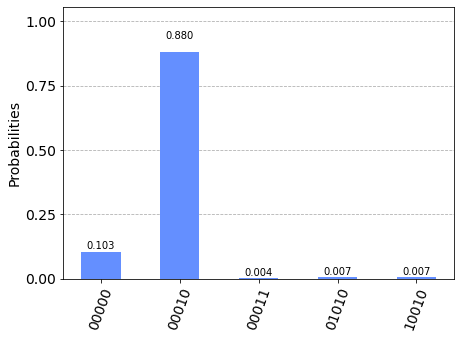

In [11]:
plot_histogram(cal_results.get_counts(cal_circuits[2]))

Tworzymy "dostosowywacz". Jako argumenty przekazujemy wyniki kalibracji i stany dla jakich te wyniki były zbierane.

In [12]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

Możemy zwizualizować wszystkie wyniki korzystając z Plot calibration.

Im ciemniejsze pola tym większe prawdopodobieństwo, że stan wejściowy jest taki jak przygotowaliśmy.
Na diagonali znajdują się prawidłowe wyniki.
Ilość komponentów poza diagonalą jest niewielka, ale ma znaczenie przy obliczeniach.

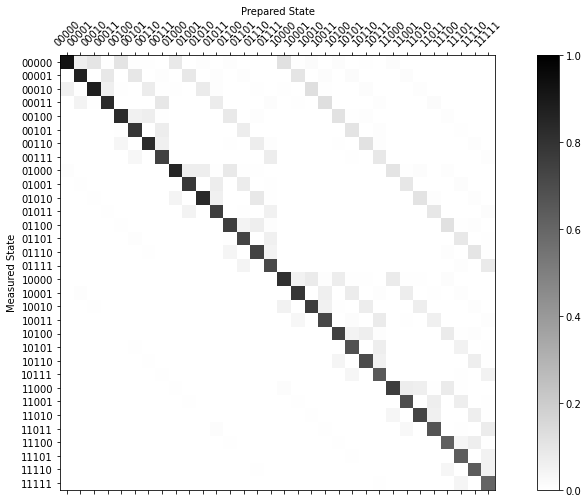

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.tick_params(axis='x', rotation=45)
meas_fitter.plot_calibration(ax=ax)


Po stworzeniu "dostosowywacza" który, wyciągnął parametry z wyników kalibracji, możemy stworzyć filtr.

In [14]:
meas_filter = meas_fitter.filter

Filtrujemy wyniki uzyskane wcześniej.

In [15]:
mitigated_result = meas_filter.apply(result_exp)

Porównujemy wyniki przed i po przefiltrowaniu.

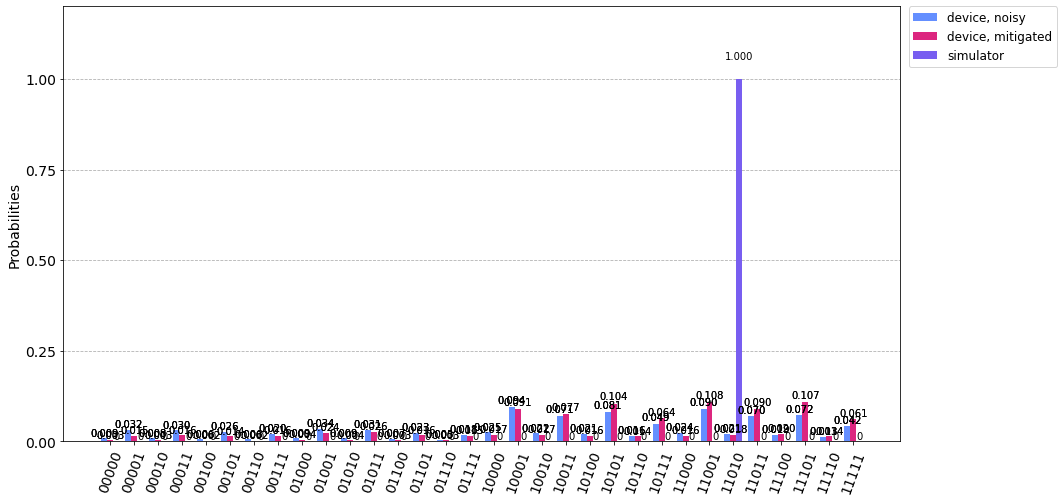

In [16]:
device_counts = result_exp.get_counts(circ)
mitigated_counts = mitigated_result.get_counts(circ)
plot_histogram([device_counts, mitigated_counts, counts], figsize=(15,8),legend=['device, noisy', 'device, mitigated', 'simulator'])

Niestety, mimo filtracji, uzyskany wynik na rzeczywistym komputrze kwantowym jest niezadowalający.
Duża ilośc kubitów i operacji na nich wykonywanych prowadzi wciąż do nieczytelnosci wyniku. Dekoherencja spowodowana odziaływaniem świata zewnętrznego.